<a href="https://colab.research.google.com/github/paulxiong/FraudDetectionUsingAutoEncoder/blob/master/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#boostx : following line will have running error, so replaced it with a folloiwng line
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))
sns.set(style='white', font_scale=1.75)

In [31]:
#boostx : since creditcard.csv is over 100M, I put it on my Google drive with public attr, and added code to read it. 
import io
import requests
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
GPATH="/content/gdrive/My Drive//FraudDetection/"

dataUrl=GPATH+"creditcard.csv"
df = pd.read_csv(dataUrl)

#boostx : following codes are trying to read url, it was successed with github url, but failed with google's. 
#dataUrl="https://drive.google.com/file/d/1eu1a5Z69f4kmJl0K54wKHzEMXc86NXZ1/view?usp=sharing"
#df = pd.read_csv("creditcard.csv") #unzip and read in data downloaded to the local directory
#s=requests.get(dataUrl).content
#df = pd.read_csv(io.StringIO(s.decode('utf-8')))
#boostx : end

df.head(n=5) #just to check you imported the dataset properly

Mounted at /content/gdrive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [32]:
df.shape #secondary check on the size of the dataframe

(284807, 31)

In [33]:
df.isnull().values.any() #check to see if any values are null, which there are not

False

In [34]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

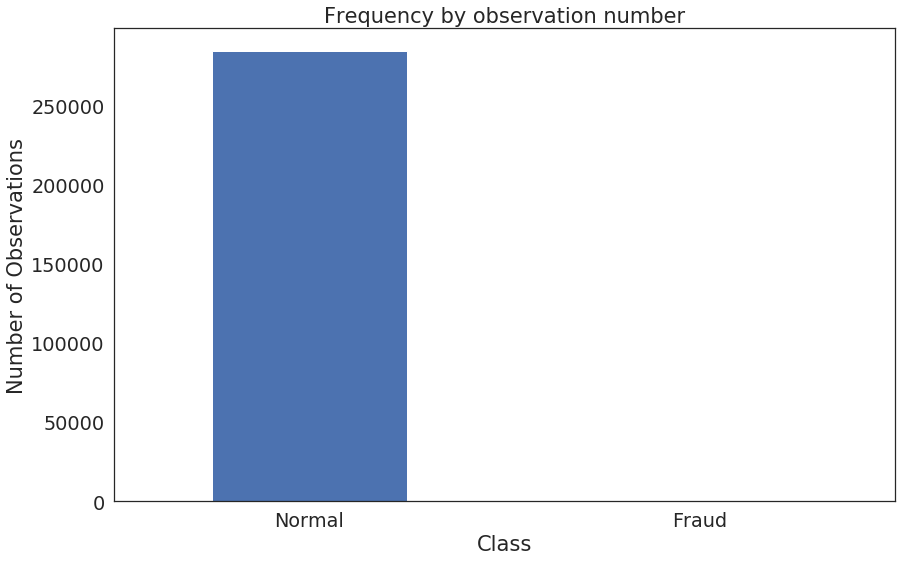

In [35]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [0]:
normal_df = df[df.Class == 0] #save normal_df observations into a separate df
fraud_df = df[df.Class == 1] #do the same for frauds

In [37]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [38]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Although the **mean is a little higher **in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods. I could run statistical tests (e.g. t-test) to support the claim that the two samples likely come from populations with similar means and deviations. However, such statistical methods are not the focus of this article on autoencoders.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


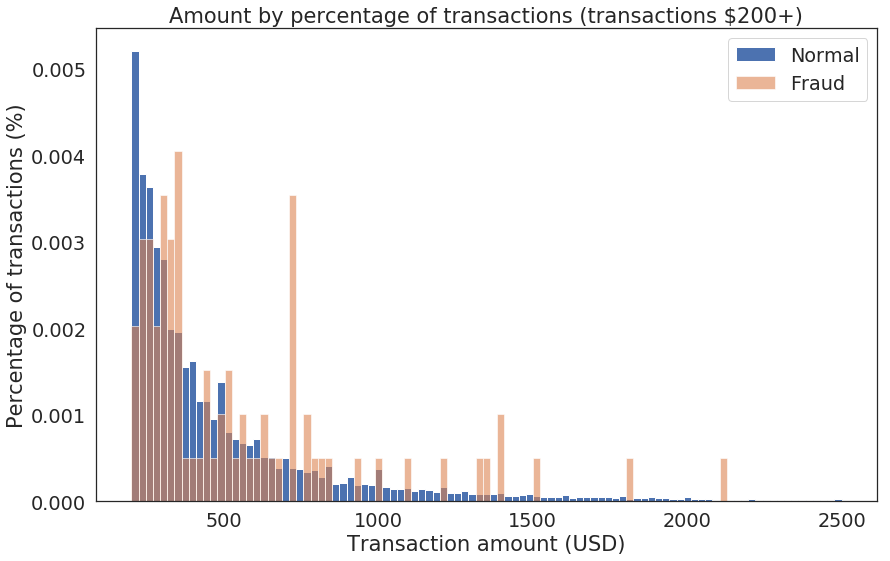

In [39]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


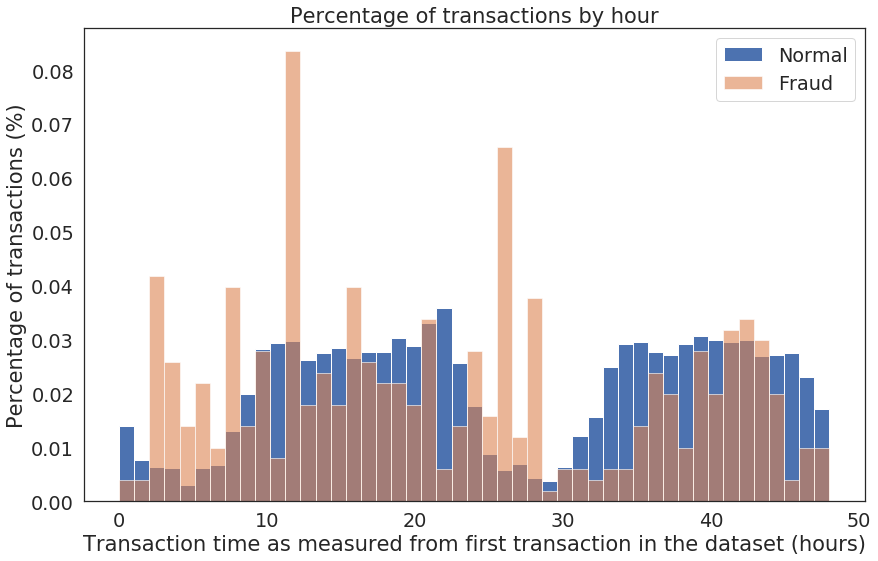

In [40]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, normed=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

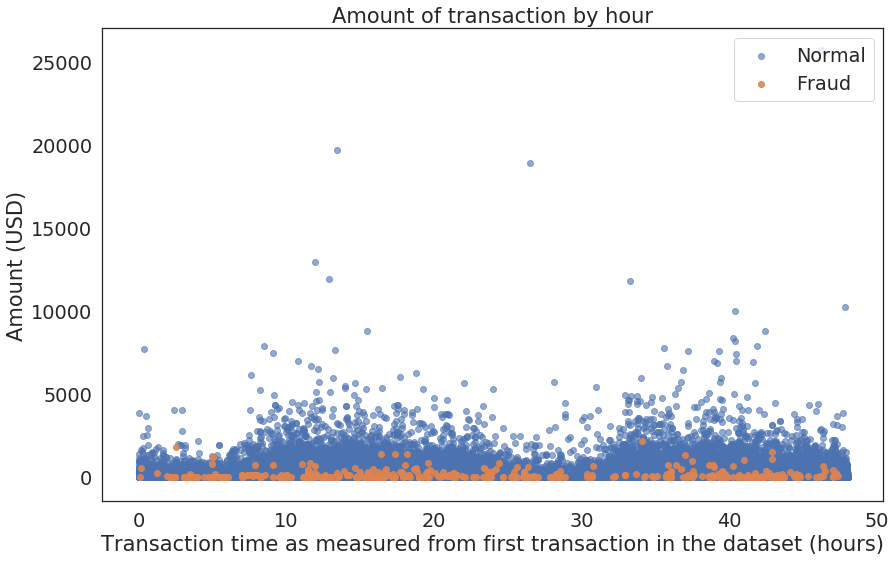

In [41]:
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [0]:
#data = df.drop(['Time'], axis=1) #if you think the var is unimportant
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [0]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

In [44]:
train_x.shape

(227468, 30)

In [45]:
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [46]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history





Train on 227468 samples, validate on 56962 samples







Epoch 1/100
227468/227468 [==============================] - 3s 15us/step - loss: 0.8641 - acc: 0.4846 - val_loss: 0.8229 - val_acc: 0.5904

Epoch 2/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7685 - acc: 0.6136 - val_loss: 0.7881 - val_acc: 0.6218
Epoch 3/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7449 - acc: 0.6343 - val_loss: 0.7726 - val_acc: 0.6409
Epoch 4/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7346 - acc: 0.6438 - val_loss: 0.7660 - val_acc: 0.6430
Epoch 5/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7281 - acc: 0.6487 - val_loss: 0.7607 - val_acc: 0.6496
Epoch 6/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7227 - acc: 0.6495 - val_loss: 0.7561 - val_acc: 0.6446
Epoch 7/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7185 - acc: 0

In [0]:
autoencoder = load_model('autoencoder_fraud.h5')

# Model Evaluation 模型评估
**Model Loss 模型损失**

The model seems to be performing well enough, although there is significant room for improvement. This simple autoencoder architecture was chosen for ease of explanation within this tutorial. However, it is my intuition that it is too simple relative to complex financial data and that overall performance could be improved by adding more hidden layers. More hidden layers would allow this network to encode more complex relationships between the input features. Please feel free to experiment with the code and let me know what you find out.

The loss of our current model seems to be converging and so more training epochs are not likely going to help. Let's explore this visually to confirm.
尽管仍有很大的改进空间，但该模型似乎表现良好。 选择这种简单的自动编码器体系结构是为了便于在本教程中进行解释。 但是，我的直觉是，相对于复杂的财务数据而言，它太简单了，可以通过添加更多隐藏层来提高整体性能。 更多的隐藏层将允许该网络对输入要素之间更复杂的关系进行编码。 请随时尝试代码，让我知道您发现了什么。 我们当前模型的损失似乎正在趋于趋同，因此更多的训练次数可能不会有所帮助。 让我们以视觉方式进行探索以确认。

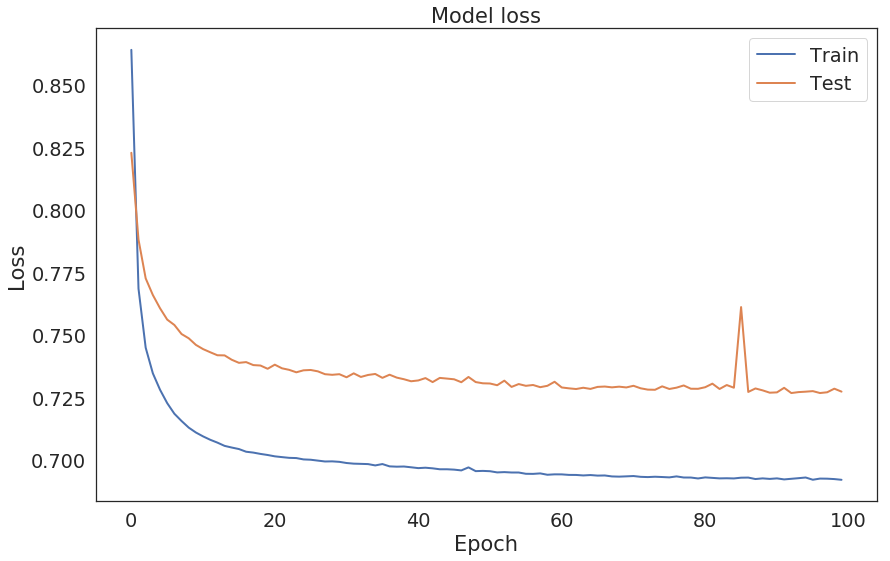

In [48]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

# Reconstruction Error Check

In [49]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.726644,0.002019
std,3.099131,0.044887
min,0.050997,0.000000
25%,0.256366,0.000000
50%,0.400878,0.000000
75%,0.622538,0.000000
max,187.362997,1.000000


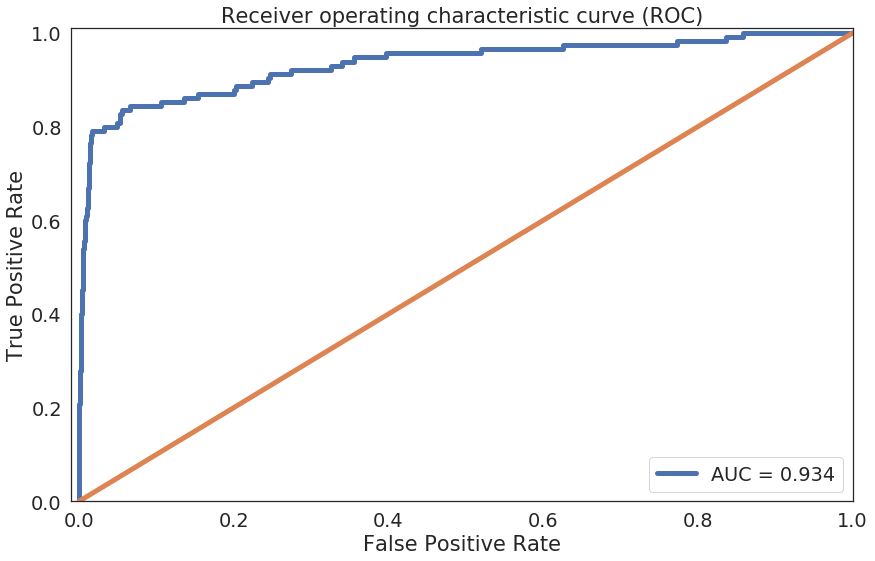

In [50]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Recall vs. Precision Thresholding 召回与精确阈值

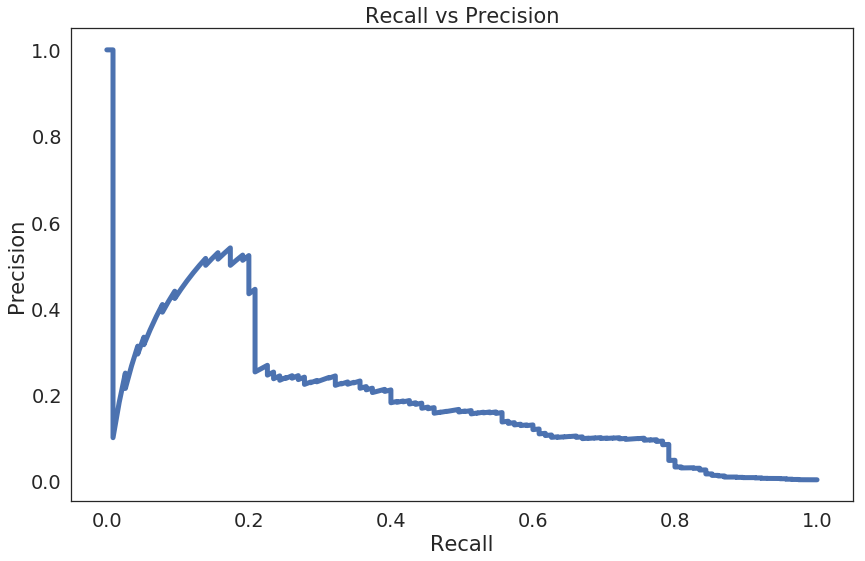

In [51]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Precision and recall are the eternal tradeoff in data science, so at some point you have to draw an arbitrary line, or a threshold. Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not. Add those two weights to the calculation and you can come up with some theoretical optimal solution. This is rarely the way it is done in practice, however, as it is hard to quantify a lot of those costs (such as customer annoyance at getting fraud alerts too frequently), or because of various structural, technical, or business rules preventing the optimized solution from being chosen.
精度和召回率是数据科学中永恒的权衡，因此在某些时候，您必须划定一条任意线或一个阈值。 划清界限的地方实际上是一项业务决策。 在这种情况下，您需要在丢失欺诈交易和错误地将交易标记为欺诈交易之间进行权衡，即使没有这样做。 将这两个权重加到计算中，您可以得出一些理论上的最佳解决方案。 但是，由于很难量化其中的许多成本（例如，客户过于频繁地获取欺诈警报而使他们烦恼），或者由于各种结构，技术或业务规则阻止了这些成本的形成，因此这实际上很难做到这一点。 选择最佳解决方案。

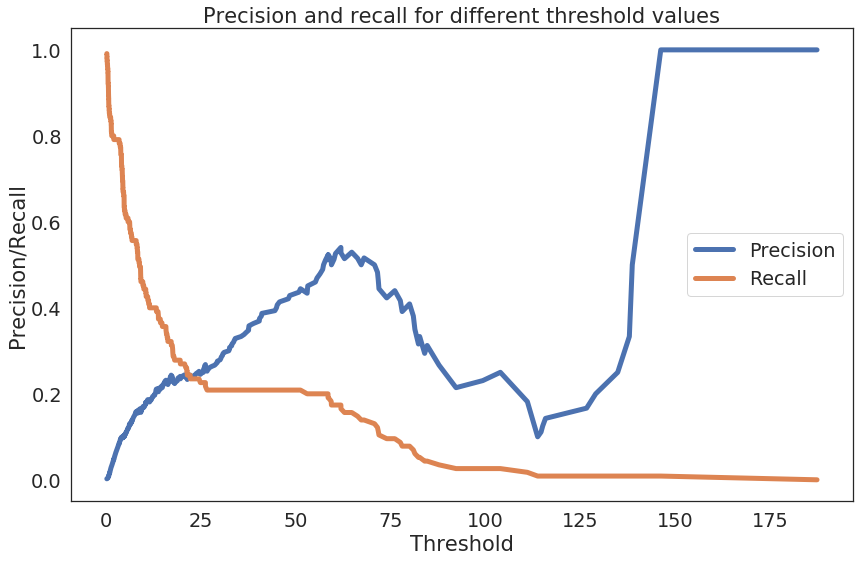

In [52]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Now that we have talked with the business client and established a threshold, let's see how that compares to reconstruction error. Where the threshold is set seems to miss the main cluster of the normal transactions, but still get a lot of the fraud transactions.
现在，我们已经与业务客户进行了交谈并确定了一个阈值，让我们看一下它与重构错误的比较。 设置阈值的位置似乎错过了正常交易的主要类别，但仍然获得了很多欺诈交易。

# Reconstruction Error vs Threshold Check

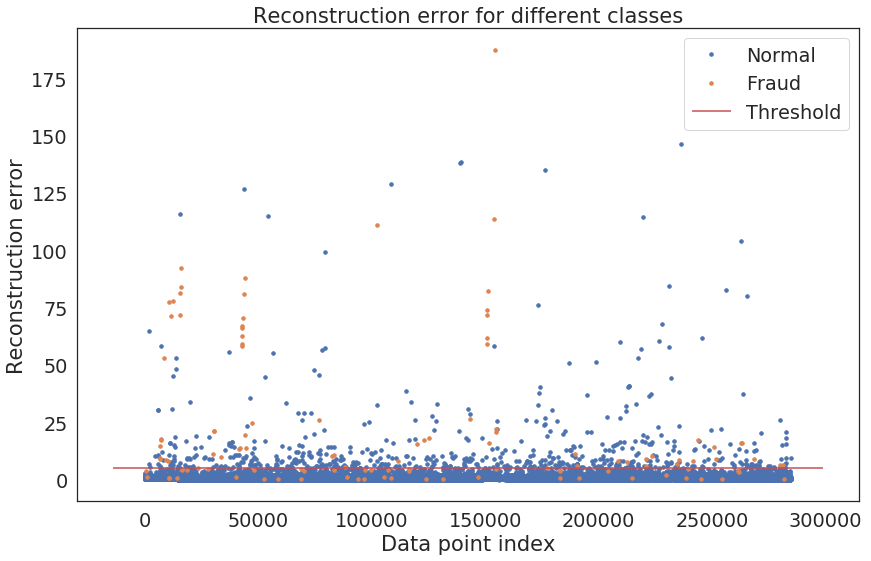

In [53]:
threshold_fixed = 5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

# Confusion Matrix 混淆矩阵
Finally, we take a look at a traditional confusion matrix for the 20% of the data we randomly held back in the testing set. Here I really take a look at the ratio of detected fraud cases to false positives. A 1:10 ratio is a fairly standard benchmark if there are no business rules or cost tradeoffs that dominate that decision. However, I can assure any data scientist that there will indeed be at least those outside influences, if not vastly more outside influences ranging from regulatory and privacy concerns to executive confidence in data and technology in general.
最后，我们来看一看传统的混淆矩阵，以了解我们随机保留在测试集中的20％数据。 在这里，我真的要看看检测到的欺诈案件与误报的比率。 如果没有业务规则或成本权衡决定该决策，则1:10的比率是相当标准的基准。 但是，我可以向任何数据科学家保证，实际上，至少会存在那些外部影响，即使不是更多，则包括监管和隐私问题到高管对数据和技术的信心等外部影响。

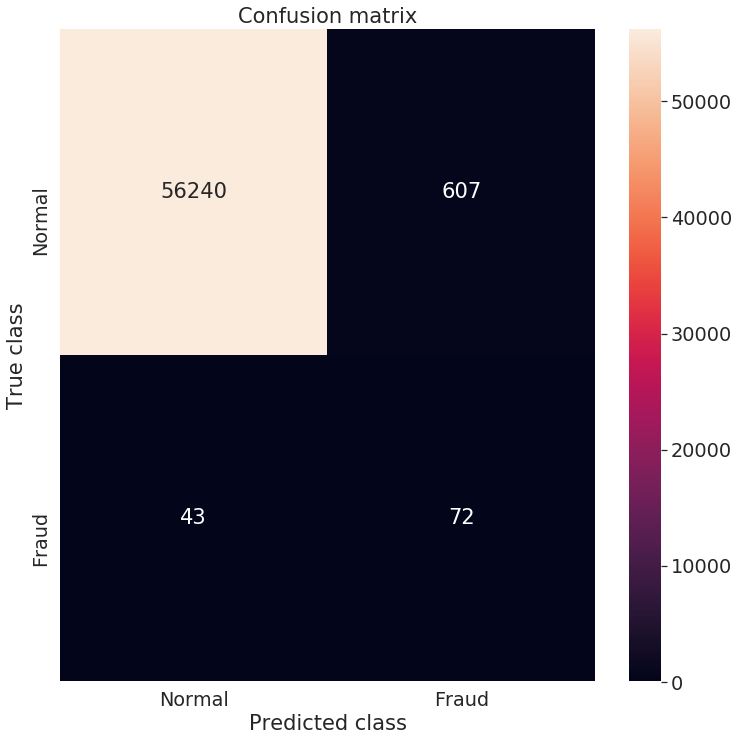

In [54]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

You will also notice we caught about 60% of the fraud cases, which might seem low at face value but remember there are no magic bullets here. Remember two things: 1) you will never catch even close to 100% of the fraud cases in any way that is even remotely real-world useful and 2) your fraud detection algorithm will be running as a part of the overall ensemble of fraud detectors that will hopefully complement your model.

Data science, as with so much else in life, is a team effort. With this tutorial and some real-world experience, it is my hope that the reader will be able to contribute more value to the organization or community in which they choose to operate.
您还会注意到，我们发现了大约60％的欺诈案件，这些案件的面值似乎很低，但请记住，这里没有神奇的子弹。 请记住两件事：1）您永远不会以甚至在现实世界中有用的任何方式捕获甚至接近100％的欺诈案件； 2）您的欺诈检测算法将作为欺诈检测器整体集合的一部分运行 希望可以补充您的模型。 数据科学与团队中的其他工作一样，都是团队共同努力的结果。 通过本教程和一些实际经验，我希望读者能够为他们选择经营的组织或社区贡献更多的价值。